# Sajad Hosseini Najafabadi
# 400301997

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, SeparableConv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import ConfusionMatrixDisplay

# 1.A: Getting to know the data

In [2]:
image_generator = ImageDataGenerator(rescale=1./255., validation_split=0.3)

In [3]:
train = image_generator.flow_from_directory(
    './data',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset="training",
)

Found 10500 images belonging to 3 classes.


In [4]:
validation = image_generator.flow_from_directory(
    './data',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset="validation",
)

Found 4500 images belonging to 3 classes.


In [5]:
test = image_generator.flow_from_directory(
    './data',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=4500,
    subset="validation",
)

Found 4500 images belonging to 3 classes.


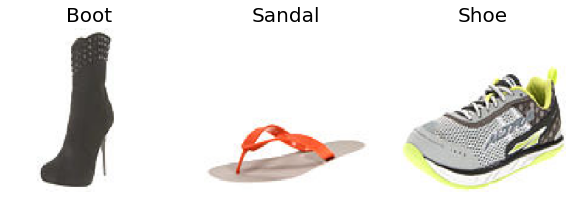

In [6]:
targets = {0: "Boot", 1: "Sandal", 2: "Shoe"}
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(10)
for i in range(3):
    x = (np.argmax(train[0][1], axis=1)==i).nonzero()
    idx = x[0][np.random.randint(len(x[0]))]
    img, label = train[0][0][idx], np.argmax(train[0][1][idx])
    axs[i].set_title(f"{targets[label]}", fontsize=20)
    axs[i].imshow(img)
    axs[i].axis(False)

# 1.B: MLP

In [7]:
MLP = Sequential()
MLP.add(Flatten(input_shape=(224, 224, 3)))
MLP.add(Dense(64, activation='relu'))
#MLP.add(Dropout(0.2))
MLP.add(Dense(32, activation='relu'))
MLP.add(Dense(3, activation='softmax'))

In [8]:
MLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 64)                9633856   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 9,636,035
Trainable params: 9,636,035
Non-trainable params: 0
_________________________________________________________________


The number of network parameters is 9,636,035

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('./saved_model/MLP.h5', monitor='val_loss', mode='min', save_best_only=True)
tb = TensorBoard(log_dir='./tensorboard/MPL')

MLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy','Precision','Recall'])

In [10]:
MLP_history = MLP.fit(train,  validation_data=validation, callbacks=[es, rlrop, mch, tb], epochs=30, verbose=1)

Epoch 1/30
329/329 [==============================] - 20s 57ms/step - loss: 2.4487 - accuracy: 0.7354 - precision: 0.7377 - recall: 0.7344 - val_loss: 1.9765 - val_accuracy: 0.6300 - val_precision: 0.6345 - val_recall: 0.6253 - lr: 0.0010
Epoch 2/30
329/329 [==============================] - 18s 56ms/step - loss: 0.9936 - accuracy: 0.7944 - precision: 0.7958 - recall: 0.7932 - val_loss: 0.6581 - val_accuracy: 0.8293 - val_precision: 0.8306 - val_recall: 0.8293 - lr: 0.0010
Epoch 3/30
329/329 [==============================] - 19s 57ms/step - loss: 1.0386 - accuracy: 0.7823 - precision: 0.7843 - recall: 0.7800 - val_loss: 0.5134 - val_accuracy: 0.8180 - val_precision: 0.8213 - val_recall: 0.8149 - lr: 0.0010
Epoch 4/30
329/329 [==============================] - 19s 57ms/step - loss: 0.4868 - accuracy: 0.8330 - precision: 0.8384 - recall: 0.8273 - val_loss: 0.3548 - val_accuracy: 0.8749 - val_precision: 0.8838 - val_recall: 0.8658 - lr: 0.0010
Epoch 5/30
329/329 [========================

In [11]:
idx = np.argmin(MLP_history.history['val_loss'])
print("The best model based on minimum validation loss has the following properties:")
print(f"val_loss: {MLP_history.history['val_loss'][idx]:.3f} | val_accuracy: {100*MLP_history.history['val_accuracy'][idx]:.2f} % \
| val_precision : {100*MLP_history.history['val_precision'][idx]:.2f} % | val_recall : {100*MLP_history.history['val_recall'][idx]:.2f} %")

The best model based on minimum validation loss has the following properties:
val_loss: 0.240 | val_accuracy: 90.80 % | val_precision : 91.43 % | val_recall : 90.33 %


141/141 [==============================] - 1s 7ms/step


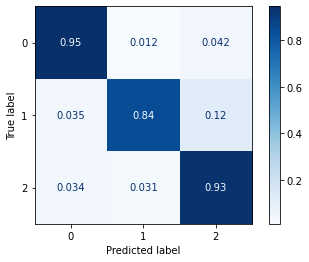

In [12]:
y_pred = np.argmax(MLP.predict(test[0][0]), axis=1)
y_true = np.argmax(test[0][1], axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', normalize='true')

# 1.C: TensorBoard

To open the Tensorboard API on the browser, we first activate the right environment of the Anaconda Prompt, then we navigate to the address where the logs folder is located. Finally, we will use the following command to serve a Tsenorbord on localhost like http://localhost:6008/.

python -m tensorboard.main --logdir=tensorboard/ --port=6008

The result is demonstrated as follows:

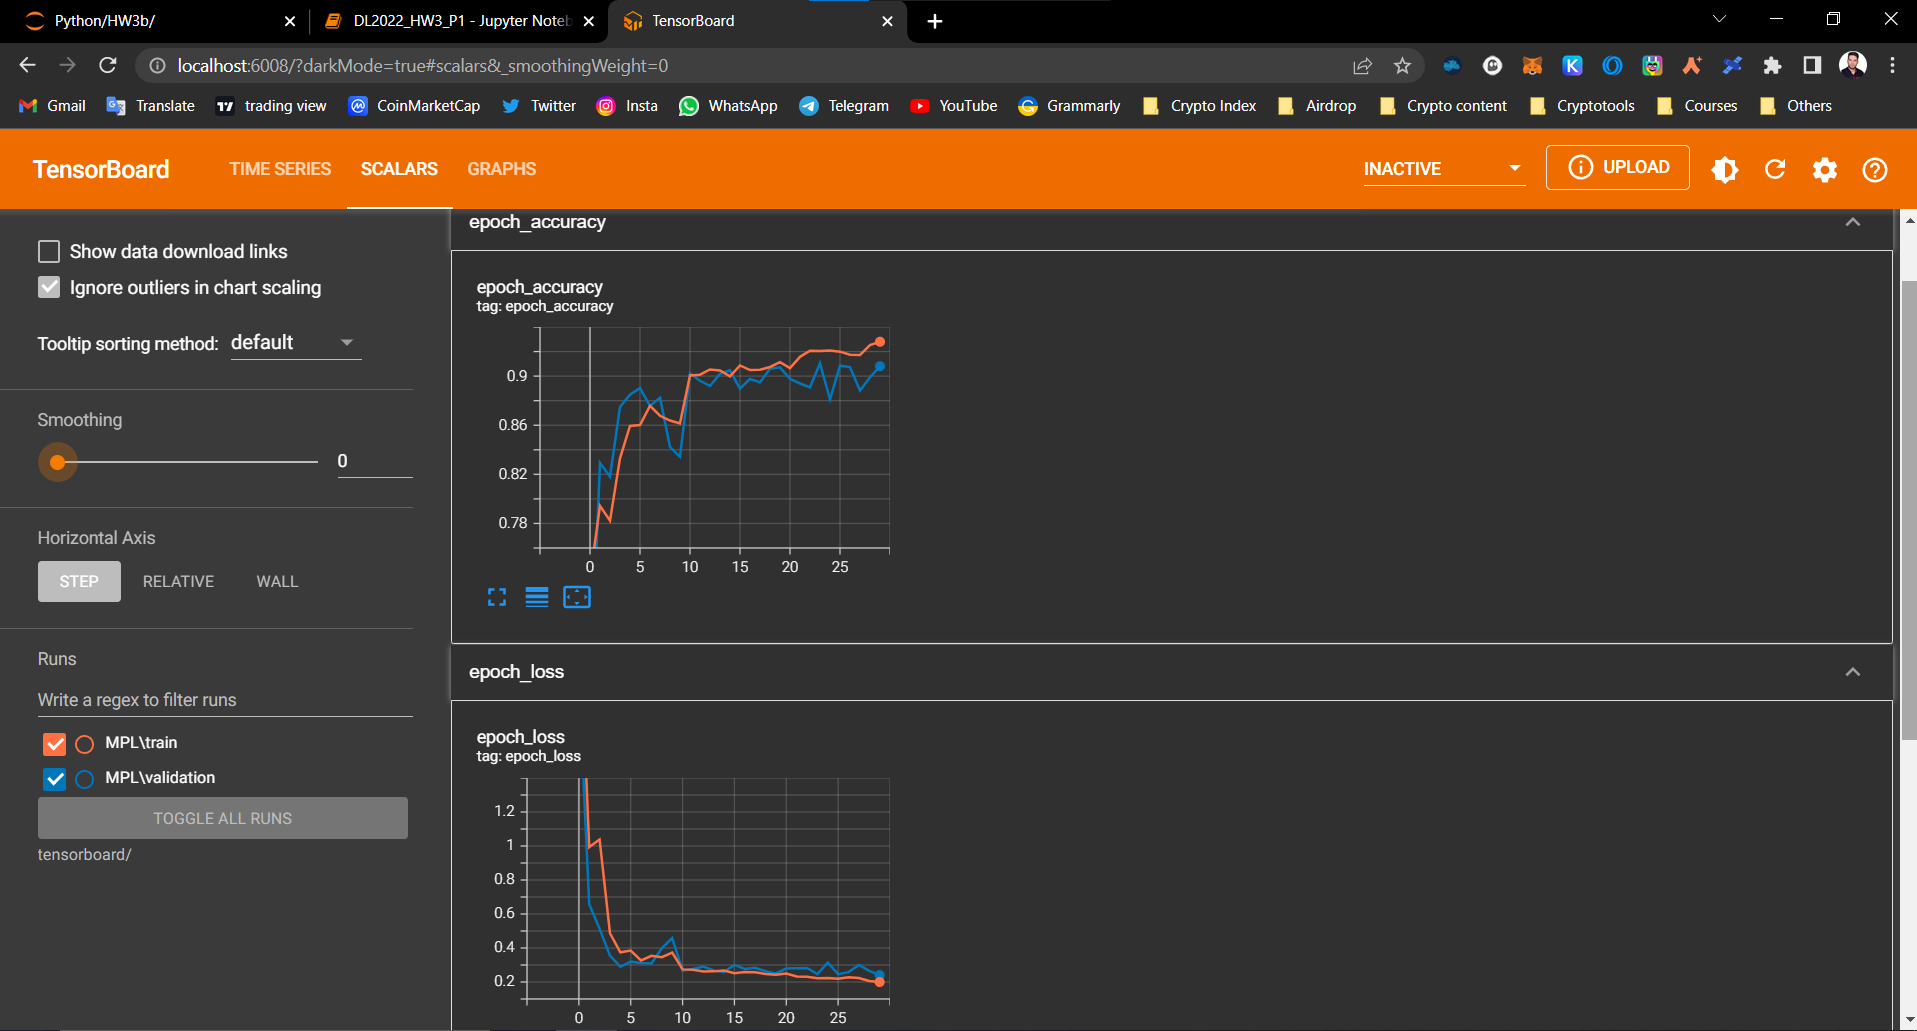

In TensorBoard, there is a smoothing filter that can be used to smooth the graphs as below:

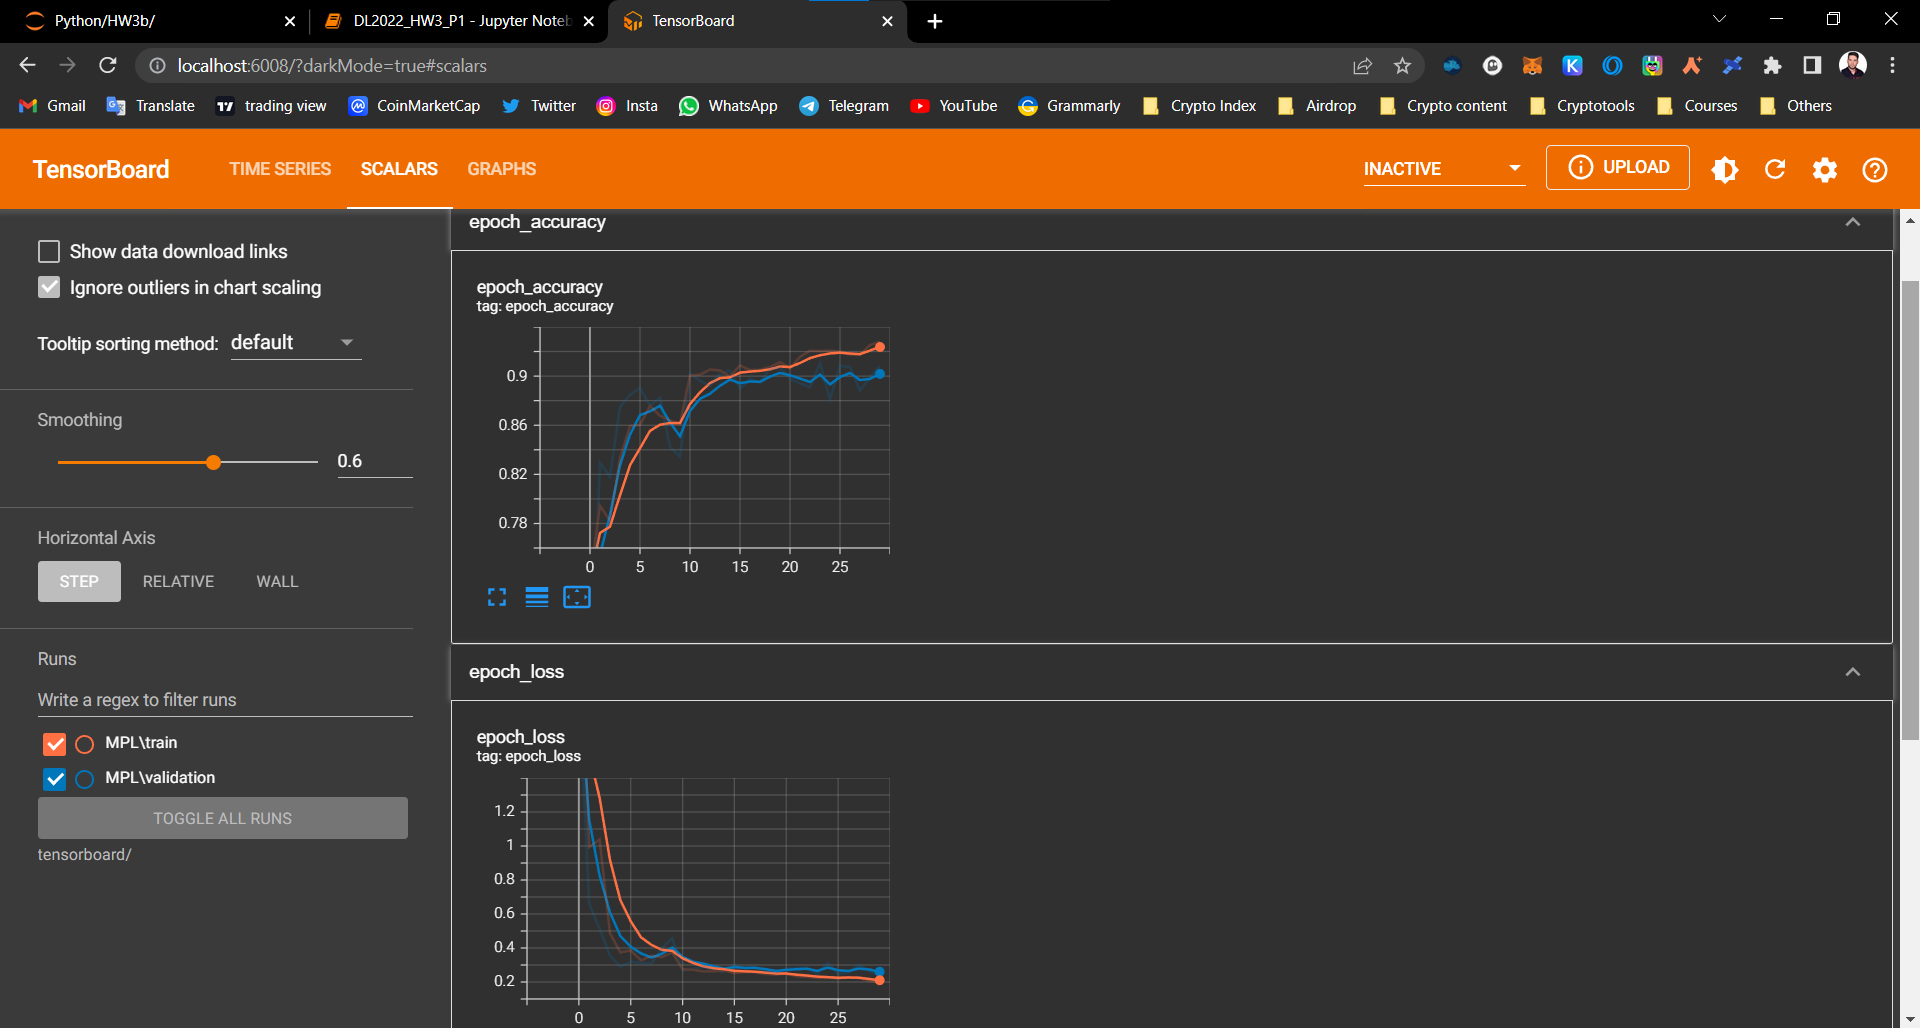

# 1.D: CNN

In [13]:
CNN = Sequential()
CNN.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(MaxPool2D(pool_size=(2, 2)))
CNN.add(Conv2D(64, (3, 3), activation='relu'))
CNN.add(MaxPool2D(pool_size=(2, 2)))
CNN.add(Conv2D(100, (3, 3), activation='relu'))
CNN.add(MaxPool2D(pool_size=(2, 2)))
CNN.add(Flatten())
CNN.add(Dense(128, activation='relu'))
CNN.add(Dense(64, activation='relu'))
#MLP.add(Dropout(0.2))
# I decided not to use the normal dropout because it doesn't give good results.
CNN.add(Dense(32, activation='relu'))
CNN.add(Dense(3, activation='softmax'))

In [14]:
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 100)       57700     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 100)     

The number of network parameters is 8,740,455 which is less than 9,636,035 (MLP).

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('./saved_model/CNN.h5', monitor='val_loss', mode='min', save_best_only=True)
tb = TensorBoard(log_dir='./tensorboard/CNN')

CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy','Precision','Recall'])

In [16]:
CNN_history = CNN.fit(train,  validation_data=validation, callbacks=[es, rlrop, mch, tb], epochs=30, verbose=1)

Epoch 1/30
329/329 [==============================] - 26s 70ms/step - loss: 0.3257 - accuracy: 0.8742 - precision: 0.9008 - recall: 0.8467 - val_loss: 0.1488 - val_accuracy: 0.9444 - val_precision: 0.9481 - val_recall: 0.9424 - lr: 0.0010
Epoch 2/30
329/329 [==============================] - 22s 68ms/step - loss: 0.1229 - accuracy: 0.9586 - precision: 0.9606 - recall: 0.9558 - val_loss: 0.1614 - val_accuracy: 0.9471 - val_precision: 0.9489 - val_recall: 0.9456 - lr: 0.0010
Epoch 3/30
329/329 [==============================] - 23s 69ms/step - loss: 0.0680 - accuracy: 0.9750 - precision: 0.9758 - recall: 0.9742 - val_loss: 0.1408 - val_accuracy: 0.9533 - val_precision: 0.9550 - val_recall: 0.9516 - lr: 0.0010
Epoch 4/30
329/329 [==============================] - 23s 68ms/step - loss: 0.0445 - accuracy: 0.9856 - precision: 0.9861 - recall: 0.9849 - val_loss: 0.1237 - val_accuracy: 0.9662 - val_precision: 0.9673 - val_recall: 0.9653 - lr: 0.0010
Epoch 5/30
329/329 [========================

In [17]:
idx = np.argmin(CNN_history.history['val_loss'])
print("The best model based on minimum validation loss has the following properties:")
print(f"val_loss: {CNN_history.history['val_loss'][idx]:.3f} | val_accuracy: {100*CNN_history.history['val_accuracy'][idx]:.2f} % \
| val_precision : {100*CNN_history.history['val_precision'][idx]:.2f} % | val_recall : {100*CNN_history.history['val_recall'][idx]:.2f} %")

The best model based on minimum validation loss has the following properties:
val_loss: 0.124 | val_accuracy: 96.62 % | val_precision : 96.73 % | val_recall : 96.53 %


141/141 [==============================] - 3s 17ms/step


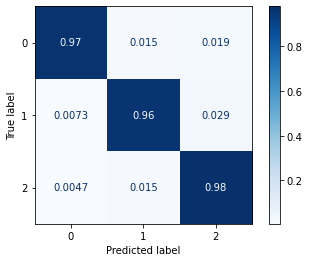

In [18]:
y_pred = np.argmax(CNN.predict(test[0][0]), axis=1)
y_true = np.argmax(test[0][1], axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', normalize='true')

Opening the Tensorboard API on the browser:

The result is demonstrated as follows:

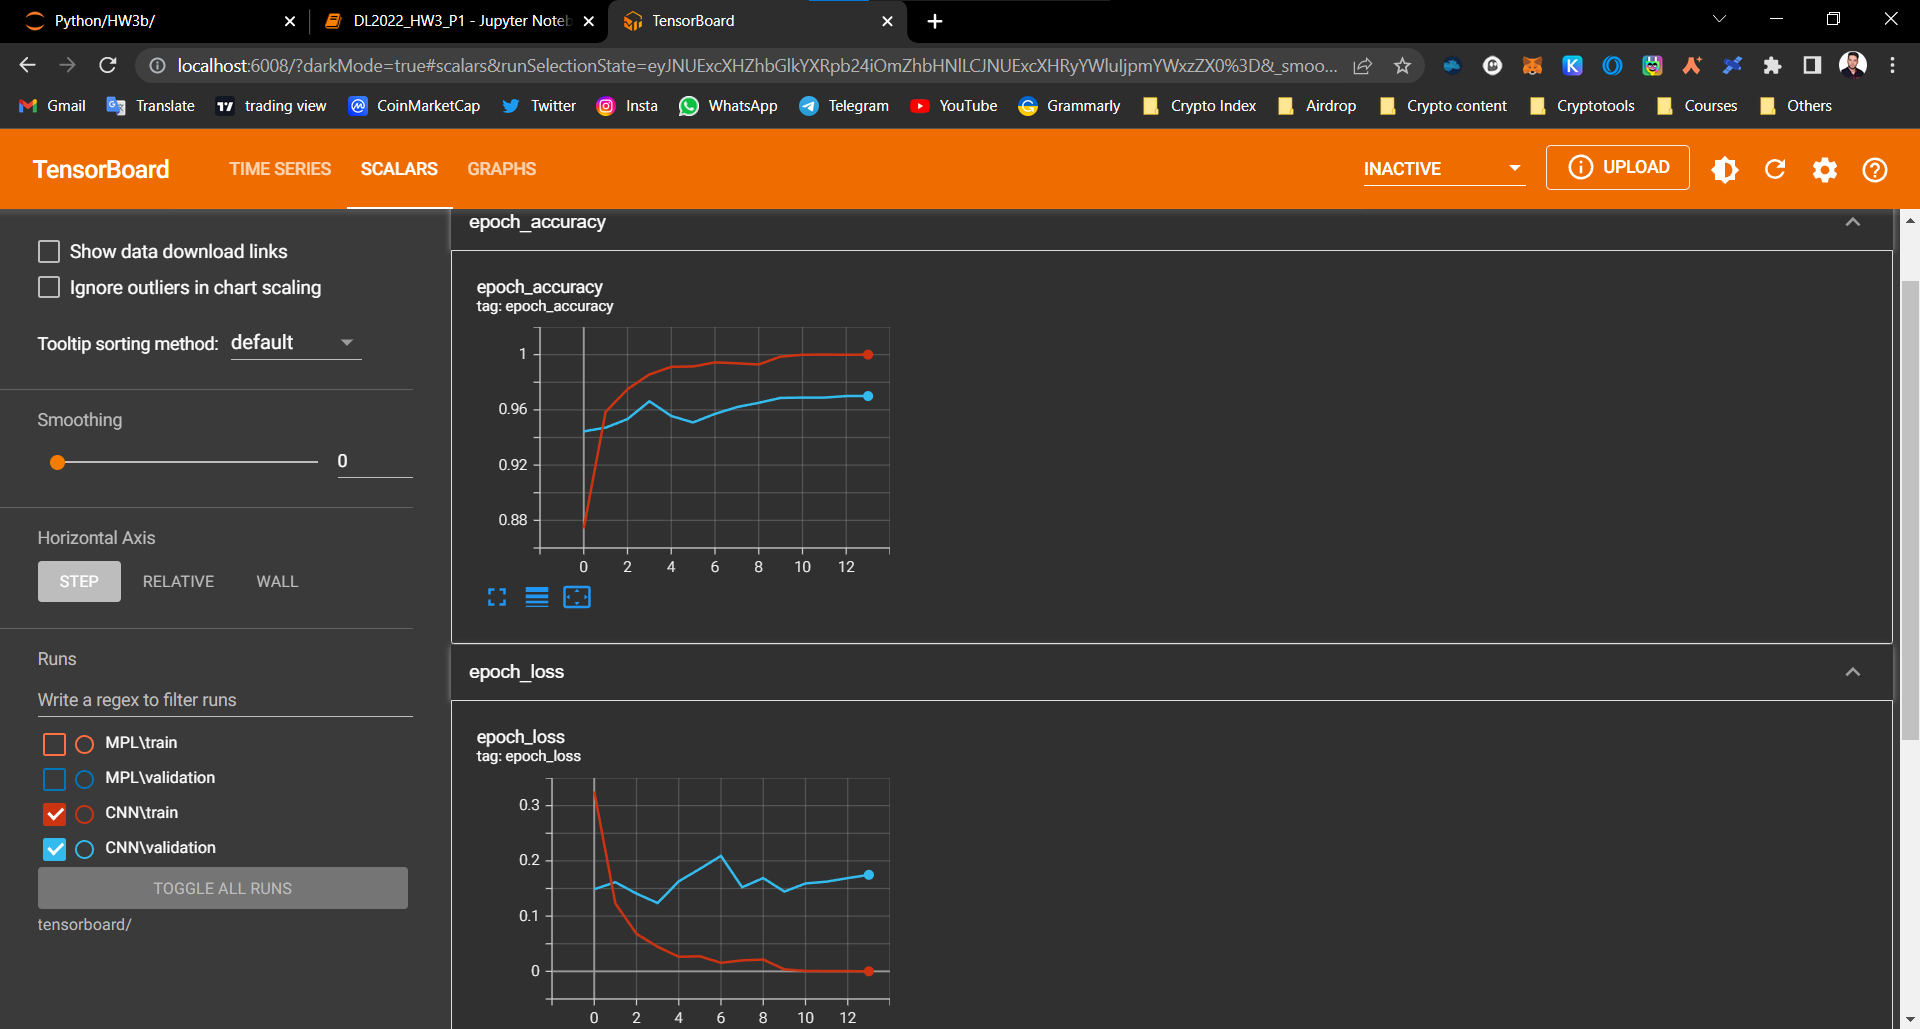

# 1.E: Comparing MLP and CNN

Even though the number of parameters of the CNN model was chosen less than the MLP model, its accuracy is much higher. Specifically, the accuracy of the CNN model after the first epoch is higher than the best iteration of the MLP.

More precisely, the results can be compared using Tensor Board

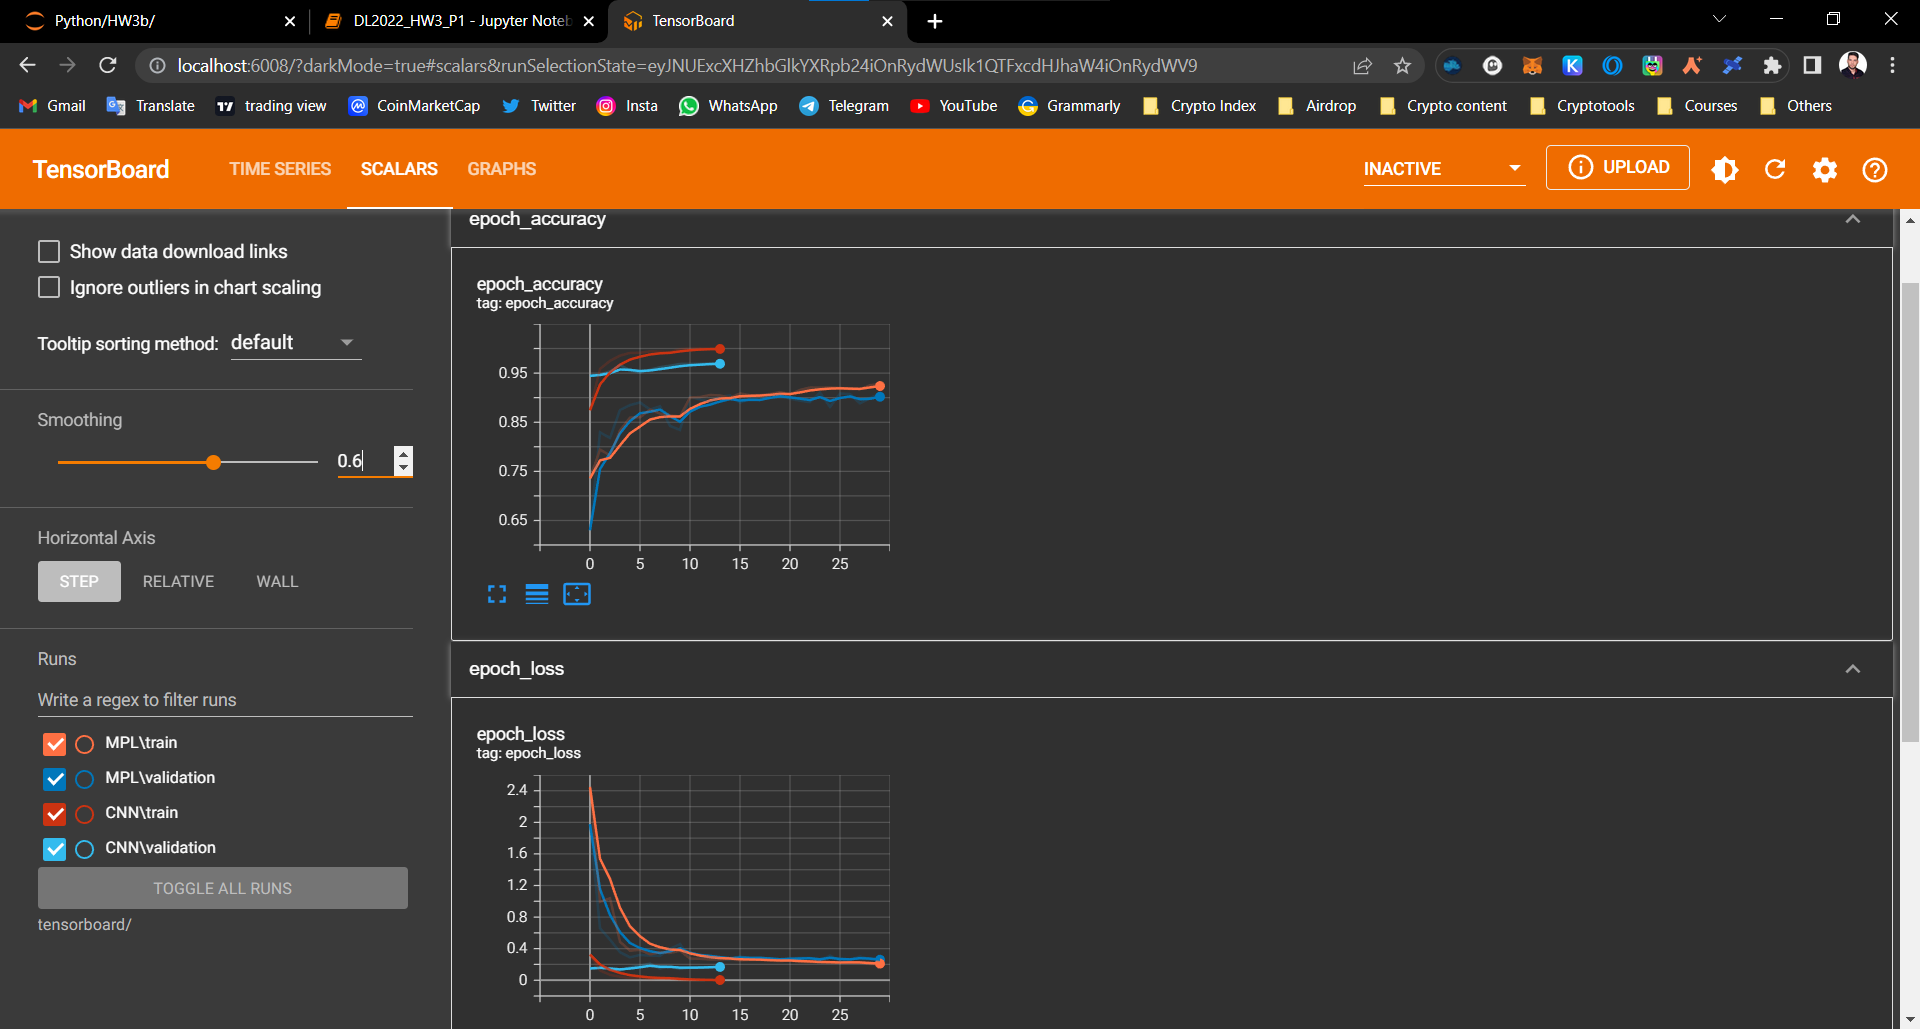

It is clear that the results of CNN model are better than MLP.

# 1.F: Block dropout

Unlike fully connected layers where dropout operation could be understood as zeroing out columns of a weight matrix in the neural network and eventually not training a neuron, dropout in convolutional layers doesn’t produce same effect as zeroing out a column of the weight matrix corresponding to the convolutional kernel and it still allows the weights in that column to be trained owing to correlation among contiguous parts of feature map. DropBlock method was introduced to combat the major drawback of Dropout being dropping features randomly when it comes to convolutional layers wherein features are spatially correlated. DropBlock technique discards features in a contiguous correlated area called block. By doing so, it is able to fulfill the purpose of generating simpler model and to put in the concept of learning a fraction of the weights in the network in each training iteration to penalize the weight matrix which in turn reduces overfitting. So, DropBlock works better than dropout on convolutional layers due to the fact that activation units in convolutional layers are spatially correlated.

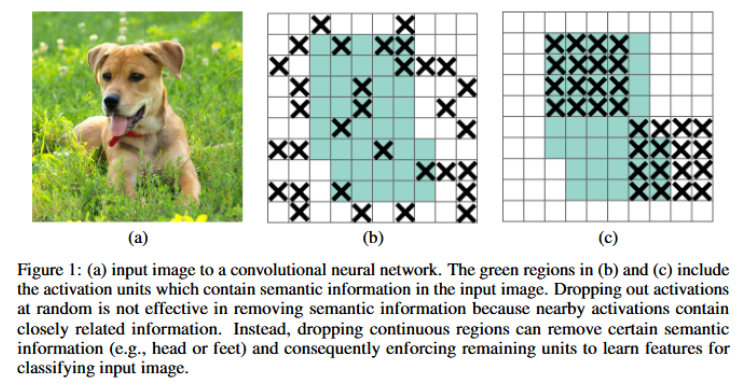



In [19]:
# Source: https://github.com/keras-team/keras-cv/blob/v0.3.4/keras_cv/layers/regularization/dropblock_2d.py#L20

from tensorflow.keras.__internal__.layers import BaseRandomLayer
from keras_cv.utils import conv_utils


class BlockDrop2D(BaseRandomLayer):

    def __init__(
        self,
        rate,
        block_size,
        seed=None,
        **kwargs,
    ):
        super().__init__(seed=seed, **kwargs)
        if not 0.0 <= rate <= 1.0:
            raise ValueError(
                f"rate must be a number between 0 and 1. " f"Received: {rate}"
            )

        self._rate = rate
        self._dropblock_height, self._dropblock_width = conv_utils.normalize_tuple(
            value=block_size, n=2, name="block_size", allow_zero=False
        )
        self.seed = seed

    def call(self, x, training=None):
        if not training or self._rate == 0.0:
            return x

        _, height, width, _ = tf.split(tf.shape(x), 4)

        # Unnest scalar values
        height = tf.squeeze(height)
        width = tf.squeeze(width)

        dropblock_height = tf.math.minimum(self._dropblock_height, height)
        dropblock_width = tf.math.minimum(self._dropblock_width, width)

        gamma = (
            self._rate
            * tf.cast(width * height, dtype=tf.float32)
            / tf.cast(dropblock_height * dropblock_width, dtype=tf.float32)
            / tf.cast(
                (width - self._dropblock_width + 1)
                * (height - self._dropblock_height + 1),
                tf.float32,
            )
        )

        # Forces the block to be inside the feature map.
        w_i, h_i = tf.meshgrid(tf.range(width), tf.range(height))
        valid_block = tf.logical_and(
            tf.logical_and(
                w_i >= int(dropblock_width // 2),
                w_i < width - (dropblock_width - 1) // 2,
            ),
            tf.logical_and(
                h_i >= int(dropblock_height // 2),
                h_i < width - (dropblock_height - 1) // 2,
            ),
        )

        valid_block = tf.reshape(valid_block, [1, height, width, 1])

        random_noise = self._random_generator.random_uniform(
            tf.shape(x), dtype=tf.float32
        )
        valid_block = tf.cast(valid_block, dtype=tf.float32)
        seed_keep_rate = tf.cast(1 - gamma, dtype=tf.float32)
        block_pattern = (1 - valid_block + seed_keep_rate + random_noise) >= 1
        block_pattern = tf.cast(block_pattern, dtype=tf.float32)

        window_size = [1, self._dropblock_height, self._dropblock_width, 1]

        # Double negative and max_pool is essentially min_pooling
        block_pattern = -tf.nn.max_pool(
            -block_pattern,
            ksize=window_size,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        # Slightly scale the values, to account for magnitude change
        percent_ones = tf.cast(tf.reduce_sum(block_pattern), tf.float32) / tf.cast(
            tf.size(block_pattern), tf.float32
        )
        return x / tf.cast(percent_ones, x.dtype) * tf.cast(block_pattern, x.dtype)

    def get_config(self):
        config = {
            "rate": self._rate,
            "block_size": (self._dropblock_height, self._dropblock_width),
            "seed": self.seed,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [20]:
CNN_DB = Sequential()
CNN_DB.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN_DB.add(MaxPool2D(pool_size=(2, 2)))
CNN_DB.add(Conv2D(64, (3, 3), activation='relu'))
CNN_DB.add(BlockDrop2D(0.2, block_size=7)) # Use BlockDrop2D here
CNN_DB.add(MaxPool2D(pool_size=(2, 2)))
CNN_DB.add(Conv2D(100, (3, 3), activation='relu'))
CNN_DB.add(MaxPool2D(pool_size=(2, 2)))
CNN_DB.add(Flatten())
CNN_DB.add(Dense(128, activation='relu'))
CNN_DB.add(Dense(64, activation='relu'))
CNN_DB.add(Dense(32, activation='relu'))
CNN_DB.add(Dense(3, activation='softmax'))

In [21]:
CNN_DB.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 block_drop2d (BlockDrop2D)  (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 100)      

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('./saved_model/CNN_DB.h5', monitor='val_loss', mode='min', save_best_only=True)

CNN_DB.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy','Precision','Recall'])

In [24]:
CNN_DB_history = CNN_DB.fit(train,  validation_data=validation, callbacks=[es, rlrop], epochs=30, verbose=1)

Epoch 1/30
329/329 [==============================] - 32s 94ms/step - loss: 0.4116 - accuracy: 0.8383 - precision: 0.8736 - recall: 0.7988 - val_loss: 0.1617 - val_accuracy: 0.9451 - val_precision: 0.9527 - val_recall: 0.9393 - lr: 0.0010
Epoch 2/30
329/329 [==============================] - 30s 92ms/step - loss: 0.1746 - accuracy: 0.9342 - precision: 0.9376 - recall: 0.9305 - val_loss: 0.1255 - val_accuracy: 0.9522 - val_precision: 0.9526 - val_recall: 0.9511 - lr: 0.0010
Epoch 3/30
329/329 [==============================] - 31s 94ms/step - loss: 0.1085 - accuracy: 0.9622 - precision: 0.9643 - recall: 0.9607 - val_loss: 0.1284 - val_accuracy: 0.9591 - val_precision: 0.9631 - val_recall: 0.9524 - lr: 0.0010
Epoch 4/30
329/329 [==============================] - 30s 92ms/step - loss: 0.0718 - accuracy: 0.9749 - precision: 0.9761 - recall: 0.9732 - val_loss: 0.1168 - val_accuracy: 0.9584 - val_precision: 0.9605 - val_recall: 0.9567 - lr: 0.0010
Epoch 5/30
329/329 [========================

In [25]:
idx = np.argmin(CNN_DB_history.history['val_loss'])
print("The best model based on minimum validation loss has the following properties:")
print(f"val_loss: {CNN_DB_history.history['val_loss'][idx]:.3f} | val_accuracy: {100*CNN_DB_history.history['val_accuracy'][idx]:.2f} % \
| val_precision : {100*CNN_DB_history.history['val_precision'][idx]:.2f} % | val_recall : {100*CNN_DB_history.history['val_recall'][idx]:.2f} %")

The best model based on minimum validation loss has the following properties:
val_loss: 0.117 | val_accuracy: 95.84 % | val_precision : 96.05 % | val_recall : 95.67 %


Therefore, as the results show, unlike normal dropout, block dropout can give good results in CNN.

# 1.G: Factorization

In [26]:
CNN_F = Sequential()
CNN_F.add(SeparableConv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
CNN_F.add(MaxPool2D(pool_size=(2, 2)))
CNN_F.add(SeparableConv2D(64, 3, activation='relu'))
CNN_F.add(MaxPool2D(pool_size=(2, 2)))
CNN_F.add(SeparableConv2D(100, 3, activation='relu'))
CNN_F.add(MaxPool2D(pool_size=(2, 2)))
CNN_F.add(Flatten())
CNN_F.add(Dense(128, activation='relu'))
CNN_F.add(Dense(64, activation='relu'))
CNN_F.add(Dense(32, activation='relu'))
CNN_F.add(Dense(3, activation='softmax'))

In [27]:
CNN_F.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_4 (Separab  (None, 222, 222, 32)     155       
 leConv2D)                                                       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 separable_conv2d_5 (Separab  (None, 109, 109, 64)     2400      
 leConv2D)                                                       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_6 (Separab  (None, 52, 52, 100)     